## DC correction

гипотеза: поправка зависит от угла, не зависит от энергии, зависит от сезона

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pylib.style as pys
import pylib.preprocess as preprocess

In [2]:
SEASON = '17'
FIT_RANGE = (-40, 20)

In [3]:
t_exp = uproot.open(f'../trees/{SEASON}/exp.root')['t']
t_mc  = uproot.open(f'../trees/{SEASON}/mc.root')['t']

In [4]:
df_exp = preprocess.read_tree(t_exp, mc=False, z_cut=12)
df_mc = preprocess.read_tree(t_mc, mc=True, z_cut=12)
df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{SEASON}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy') 

In [45]:
def correct(df_exp, df_mc, threshold_energy=None):
    df_exp = df_exp.query(f'x1>{FIT_RANGE[0]}&x1<{FIT_RANGE[1]}')
    df_mc = df_mc.query(f'x1>{FIT_RANGE[0]}&x1<{FIT_RANGE[1]}')
    energies = df_exp.index.unique().intersection(df_mc.index.unique())
    ang_cut = 0.2
    if threshold_energy is not None:
        energies = energies[energies < threshold_energy]
    get_thetas = lambda df: (df['tth[0]'].values, df['tth[1]'].values)
    get_moms = lambda df: (df['tptot[0]'].values, df['tptot[1]'].values)
    get_lengths = lambda df: np.sum(np.abs(df['tth[0]'] - np.pi/2) < ang_cut) + np.sum(np.abs(df['tth[1]'] - np.pi/2) < ang_cut)
    th_exp, th_mc, w_mc = np.array([]), np.array([]), np.array([])
    for energy in energies:
        th0_exp, th1_exp = get_thetas(df_exp.loc[energy]) 
        th0_mc, th1_mc = get_thetas(df_mc.loc[energy])
        th_exp = np.concatenate((th_exp, th0_exp, th1_exp))
        th_mc = np.concatenate((th_mc, th0_mc, th1_mc))
        w_mc = np.concatenate((w_mc, np.full(th0_mc.size + th1_mc.size, get_lengths(df_exp.loc[energy])/get_lengths(df_mc.loc[energy]))))
    return (th_exp, th_mc, w_mc)

In [46]:
exp, mc, weights = correct(df_exp, df_mc, 810)

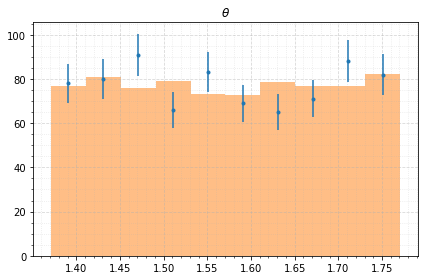

In [7]:
hist_range, hist_bins = (np.pi/2-0.2, np.pi/2+0.2), 10
# plt.hist(a, range=hist_range, bins=hist_bins);
pys.hep_histo(exp, bins=hist_bins, range=hist_range);
plt.hist(mc, weights=weights, range=hist_range, bins=hist_bins, alpha=0.5);
pys.my_style(title='$\\theta$')

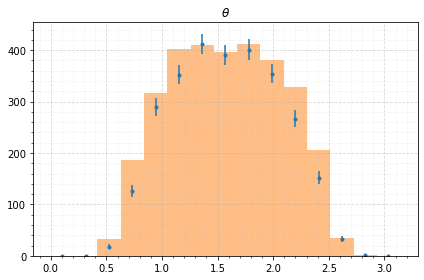

In [8]:
hist_range, hist_bins = (0, np.pi), 15
# plt.hist(a, range=hist_range, bins=hist_bins);
pys.hep_histo(exp, bins=hist_bins, range=hist_range);
plt.hist(mc, weights=weights, range=hist_range, bins=hist_bins, alpha=0.5);
pys.my_style(title='$\\theta$')

In [9]:
exp_hist, bins = np.histogram(exp, bins=hist_bins, range=hist_range)
mc_hist, bins = np.histogram(mc, bins=hist_bins, range=hist_range, weights=weights)

exp_hist = np.ma.masked_array(exp_hist)
exp_hist[exp_hist==0] = np.ma.masked

mc_hist = np.ma.masked_array(mc_hist)
mc_hist[exp_hist==0] = np.ma.masked

In [10]:
mc_errs = []
for left, right in zip(bins[:-1], bins[1:]):
    mc_errs.append( np.sqrt( np.sum( np.extract((mc<=right)&(mc>left), weights)**2 ) ) )
mc_errs = np.array(mc_errs)

/store17/petrov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


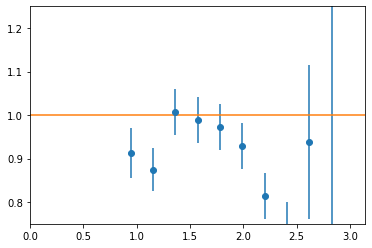

In [11]:
ratio = exp_hist/mc_hist
ratio_err = ratio*np.sqrt( (1/np.sqrt(exp_hist))**2 + (mc_errs/mc_hist)**2 )
plt.errorbar(x=(bins[:-1]+bins[1:])/2, y=ratio, yerr=ratio_err, fmt='o')
plt.plot(hist_range, [1,1])
plt.xlim(hist_range)
plt.ylim(0.75, 1.25);

In [12]:
ratio[ratio.mask] = 1
ratio_err[ratio_err.mask] = 0
df = pd.DataFrame({'left': bins[:-1],
 'right': bins[1:],
 'dc_corr': ratio.data,
 'dc_corr_err': ratio_err.data,
})
df.loc[df.dc_corr_err>df.dc_corr, ['dc_corr', 'dc_corr_err']] = [1, 0]
# df.to_csv(f'../data/{SEASON}/results/dc_corrections.csv')

## Подсчитываю поправки

In [14]:
df_mc_cut = df_mc.query(f'x1>{FIT_RANGE[0]}&x1<{FIT_RANGE[1]}').copy()

In [18]:
th0 = np.digitize(df_mc_cut['tth[0]'], df.right)
th1 = np.digitize(df_mc_cut['tth[0]'], df.right)
th0, th1 = df.loc[th0, ['dc_corr', 'dc_corr_err']], df.loc[th1, ['dc_corr', 'dc_corr_err']]
df_mc_cut['th0_corr'] = th0['dc_corr'].values
df_mc_cut['th1_corr'] = th1['dc_corr'].values
df_mc_cut['dc_corr'] = th0['dc_corr'].values*th1['dc_corr'].values
df_mc_cut['dc_corr_err'] = df_mc_cut['dc_corr']*np.sqrt( (th0['dc_corr_err'].values/th0['dc_corr'].values)**2 + \
                                                (th1['dc_corr_err'].values/th1['dc_corr'].values)**2 )

<ErrorbarContainer object of 3 artists>

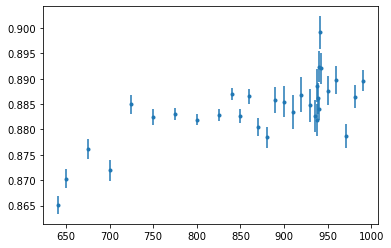

In [19]:
df_mc2 = df_mc_cut.assign(dccorr_err=df_mc_cut.dc_corr_err**2).groupby('ebeam').\
            agg(dccorr=('dc_corr', 'mean'), n=('dc_corr', 'count'), dccorr_err=('dccorr_err', 'sum'))
# df_mc2['dccorr']*=dt['full_corr']
df_mc2['dccorr_err'] = np.sqrt(df_mc2['dccorr_err'])/df_mc2['n']
plt.errorbar(x=df_mc2.index, y=df_mc2.dccorr, yerr=df_mc2.dccorr_err, fmt='.')
# plt.ylim(1, 1.3);

In [72]:
# df_mc2[['dccorr', 'dccorr_err']].to_csv(f'../data/{SEASON}/results/dc.csv')

In [73]:
df_mc2

,dccorr,n,dccorr_err
ebeam,,,
641.0,0.870917,1539,0.001816
650.0,0.874644,1392,0.001866
675.0,0.882924,1295,0.002057
700.0,0.878066,1177,0.002095
725.0,0.886216,1457,0.001817
750.0,0.884587,2107,0.001514
775.0,0.885594,3277,0.001229
800.0,0.883542,3736,0.001135
825.0,0.884907,3592,0.001173
